We take our 512x512 resized images and produced tiles images of 127x128

In [74]:
import cv2
from PIL import Image
import os 
from glob import glob
import pathlib

import numpy as np # linear algebra
import matplotlib.pylab as plt

import random

## Tile 512x512 to multiple 128x128

Note that this will result in 4x the files

In [58]:
INPUT_PATH_PNG = '/home/ubuntu/fastai/data/roads/mass_roads_png_512'
OUTPUT_PATH_PNG = '/home/ubuntu/fastai/data/roads/mass_roads_png_128'

image_x, image_y, image_layers = (512,512,3)

In [47]:
tile_size = (128,128)
offset = (128,128)
#bin_size = 200

### Check that the destination directories are in place

In [5]:
def mk_dirs(path, list_of_data_sets):
    for p in list_of_data_sets:
        sat = '{}/{}/sat'.format(path, p)
        map = '{}/{}/map'.format(path, p)
        pathlib.Path(sat).mkdir(parents=True, exist_ok=True)
        pathlib.Path(map).mkdir(parents=True, exist_ok=True) 

In [6]:
mk_dirs(OUTPUT_PATH_PNG_128, ['train', 'valid', 'test'])

In [7]:
def get_ids(path, data_set):
    ''' Look in the "sat" directory and get the filenames from here. The
    same filenames appear in the "map" directory - no need to do it as well.'''
    sat_dir = '{}/{}/sat/'.format(path, data_set)
    file_dir = '{}*.png'.format(sat_dir)
    files = glob(file_dir)
    ids = [s[len(sat_dir):-4] for s in files]
    return ids

In [8]:
get_ids(INPUT_PATH_PNG, 'train')[:5]

['22978885_15', '25679230_15', '22678870_15', '17128885_15', '23428960_15']

In [9]:
get_ids(INPUT_PATH_PNG, 'valid')[:5]

['24479170_15', '17878735_15', '18178780_15', '10978735_15', '22978990_15']

### Tile the training data

Get the full path file names

In [27]:
def crop_image_cordinates(tile_size, offset, image_x, image_y):
    for i in range(0, image_x, tile_size[0]):
        for j in range(0, image_y, tile_size[1]):
            tl_x = i
            tl_y = j
            br_x = i + tile_size[0]
            br_y = j + tile_size[1]
            yield (tl_x, tl_y, br_x, br_y)


In [59]:
print(tile_size, offset, image_x, image_y)
for tpl in crop_image_cordinates(tile_size, offset, image_x, image_y):
    print(tpl)

(128, 128) (128, 128) 512 512
(0, 0, 128, 128)
(0, 128, 128, 256)
(0, 256, 128, 384)
(0, 384, 128, 512)
(128, 0, 256, 128)
(128, 128, 256, 256)
(128, 256, 256, 384)
(128, 384, 256, 512)
(256, 0, 384, 128)
(256, 128, 384, 256)
(256, 256, 384, 384)
(256, 384, 384, 512)
(384, 0, 512, 128)
(384, 128, 512, 256)
(384, 256, 512, 384)
(384, 384, 512, 512)


In [60]:
def crop_image(data_set, fn, tile_size, offset):
    map_file = '{}/{}/map/{}.png'.format(INPUT_PATH_PNG, data_set, fn)
    sat_file = '{}/{}/sat/{}.png'.format(INPUT_PATH_PNG, data_set, fn)
    
    map_img = Image.open(map_file)
    sat_img = Image.open(sat_file)

    counter = 0
    
    for tpl in crop_image_cordinates(tile_size, offset, image_x, image_y):
        map_img_crop = map_img.crop((tpl[0], tpl[1], tpl[2], tpl[3]))
            
        #white_pixels = sum(map_img_crop.point(lambda x: 255 if x else 0).convert("L").point(bool).getdata())
        #if white_pixels > bin_size:
        sat_img_crop = sat_img.crop((tpl[0], tpl[1], tpl[2], tpl[3]))
            
        map_output_file = '{}/{}/map/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, counter)
        sat_output_file = '{}/{}/sat/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, counter)
            
        map_img_crop.save(map_output_file)
        sat_img_crop.save(sat_output_file)

        counter += 1

In [61]:
train_ids = get_ids(INPUT_PATH_PNG, 'train')

In [62]:
crop_image('train', train_ids[0], tile_size, offset)

In [63]:
for fn in train_ids:
    crop_image('train', fn, tile_size, offset)

#### Check the size of the training set

In [68]:
!ls ~/fastai/data/roads/mass_roads_png_512/train/map | wc -l
!ls ~/fastai/data/roads/mass_roads_png_128/train/map | wc -l

1108
17728


### Tile the validation data

In [64]:
valid_ids = get_ids(INPUT_PATH_PNG, 'valid')
for fn in valid_ids:
    crop_image('valid', fn, tile_size, offset)


#### Check the size of the validation set

In [69]:
!ls ~/fastai/data/roads/mass_roads_png_512/valid/map | wc -l
!ls ~/fastai/data/roads/mass_roads_png_128/valid/map | wc -l

63
1008


### Tile the test set

In [70]:
valid_ids = get_ids(INPUT_PATH_PNG, 'test')
for fn in valid_ids:
    crop_image('test', fn, tile_size, offset)

#### Check the size of the test sets

In [71]:
!ls ~/fastai/data/roads/mass_roads_png_512/test/map | wc -l
!ls ~/fastai/data/roads/mass_roads_png_128/test/map | wc -l

49
784


### Display a random image from the training set

In [72]:
def display_image(fn, data_set, tile_size):
    plt.figure(figsize=(20, 20))

    map_output_file = '{}/{}/map/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, 0)
    sat_output_file = '{}/{}/sat/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, 0)
 
    mask_img = Image.open(map_output_file)
    mask = np.asarray(mask_img)
    
    sat_img = Image.open(sat_output_file)
    img = np.asarray(sat_img)

    img_masked = cv2.bitwise_and(img, img, mask=mask)

    print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask)
    plt.subplot(133)
    plt.imshow(img_masked)

Image shape: (128, 128, 3) | image type: uint8 | mask shape: (128, 128) | mask type: uint8


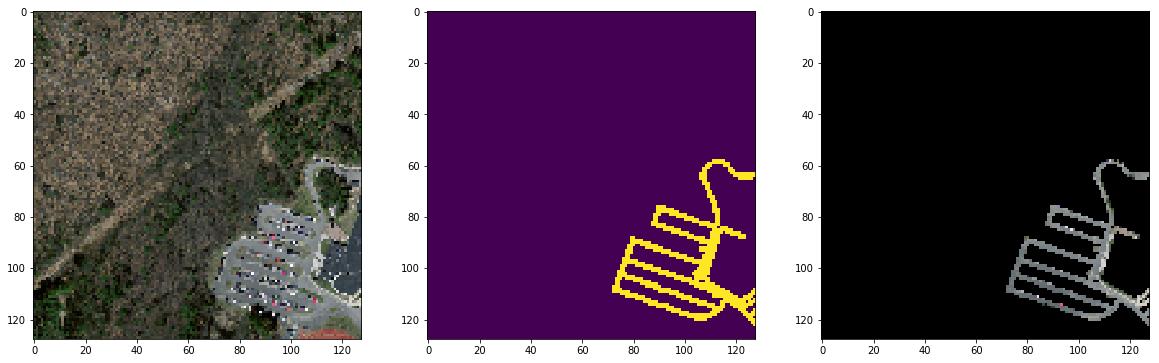

In [79]:
f = random.choice(train_ids)
display_image(f, 'train', tile_size)